In [23]:

import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import random
import os

print(os.listdir('../AIBabySitter/database/'))


['test', 'train']


In [24]:
FAST_RUN = False
IMAGE_WIDTH=227
IMAGE_HEIGHT=227
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [25]:
filenames = os.listdir('../AIBabySitter/database/train/')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'sittingup' or category == 'faceup':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [26]:
df

filename  category
0     climb. (1).jpeg         0
1    climb. (10).jpeg         0
2    climb. (11).jpeg         0
3    climb. (12).jpeg         0
4    climb. (13).jpeg         0
..                ...       ...
253   stand. (5).jpeg         0
254   stand. (6).jpeg         0
255   stand. (7).jpeg         0
256   stand. (8).jpeg         0
257   stand. (9).jpeg         0

[258 rows x 2 columns]

<AxesSubplot:>

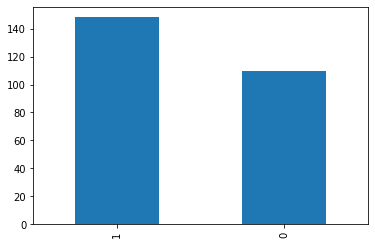

In [27]:
df['category'].value_counts().plot.bar()

facedown. (44).jpeg


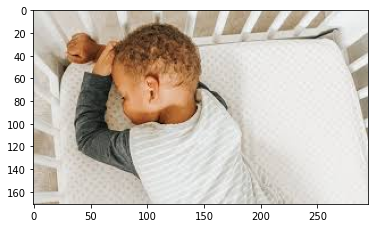

In [28]:
sample = random.choice(filenames)
image = load_img('../AIBabySitter/database/train/'+sample)
plt.imshow(image)
print(sample)

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), 
                 kernel_size=(11,11), strides=(4,4)))
model.add(Activation('relu'))
#-----------------------------------------------------------------------------------------

# Max Pooling 
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))) 
# Batch Normalisation before passing it to the next layer
# Batch Normalisation is used to prevent them from saturating 
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
model.add(Activation('relu'))
#-----------------------------------------------------------------------------------------

# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
#-----------------------------------------------------------------------------------------

# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
# Batch Normalisation
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# Passing it to a dense layer which is the Fully Connected layer.
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(4096, input_shape=(IMAGE_WIDTH * IMAGE_HEIGHT * IMAGE_CHANNELS,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# Output Layer
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

# (4) Compile 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_20 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
activation_21 (Activation)   (None, 27, 27, 256)       0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 256)      

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10) 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [12]:
df["category"] = df["category"].replace({0: 'unsafe', 1: 'safe'}) 

In [13]:
df

filename category
0     climb. (1).jpeg   unsafe
1    climb. (10).jpeg   unsafe
2    climb. (11).jpeg   unsafe
3    climb. (12).jpeg   unsafe
4    climb. (13).jpeg   unsafe
..                ...      ...
253   stand. (5).jpeg   unsafe
254   stand. (6).jpeg   unsafe
255   stand. (7).jpeg   unsafe
256   stand. (8).jpeg   unsafe
257   stand. (9).jpeg   unsafe

[258 rows x 2 columns]

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

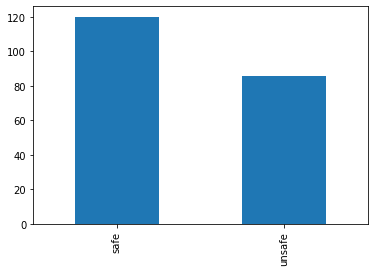

In [15]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

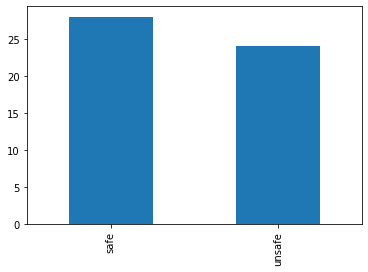

In [16]:
validate_df['category'].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [18]:
import tensorflow as tf
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    dtype=tf.float32
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    '../AIBabySitter/database/train', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 206 validated image filenames belonging to 2 classes.


In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
   '../AIBabySitter/database/train', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 52 validated image filenames belonging to 2 classes.


In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    '../AIBabySitter/database/train', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


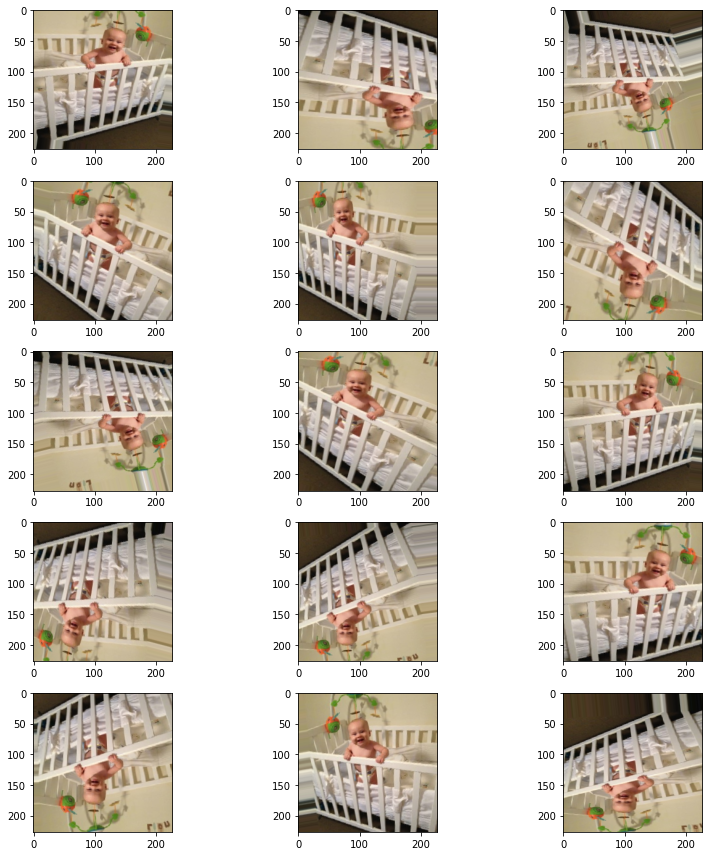

In [22]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [23]:
epochs = 3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

Epoch 1/50
13/13 [==============================] - 10s 736ms/step - loss: 2.3398 - accuracy: 0.4974 - val_loss: 51.4458 - val_accuracy: 0.4222
Epoch 2/50
13/13 [==============================] - 7s 553ms/step - loss: 1.5173 - accuracy: 0.5864 - val_loss: 163.3602 - val_accuracy: 0.4444
Epoch 3/50
13/13 [==============================] - 8s 605ms/step - loss: 0.8587 - accuracy: 0.6649 - val_loss: 209.9674 - val_accuracy: 0.5111
Epoch 4/50
13/13 [==============================] - 7s 556ms/step - loss: 0.9799 - accuracy: 0.6178 - val_loss: 116.7682 - val_accuracy: 0.4444
Epoch 5/50
13/13 [==============================] - ETA: 0s - loss: 0.9154 - accuracy: 0.5707
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
13/13 [==============================] - 7s 553ms/step - loss: 0.9154 - accuracy: 0.5707 - val_loss: 40.9742 - val_accuracy: 0.4667
Epoch 6/50
13/13 [==============================] - 7s 571ms/step - loss: 0.8625 - accuracy: 0.6492 - val_loss: 21.512

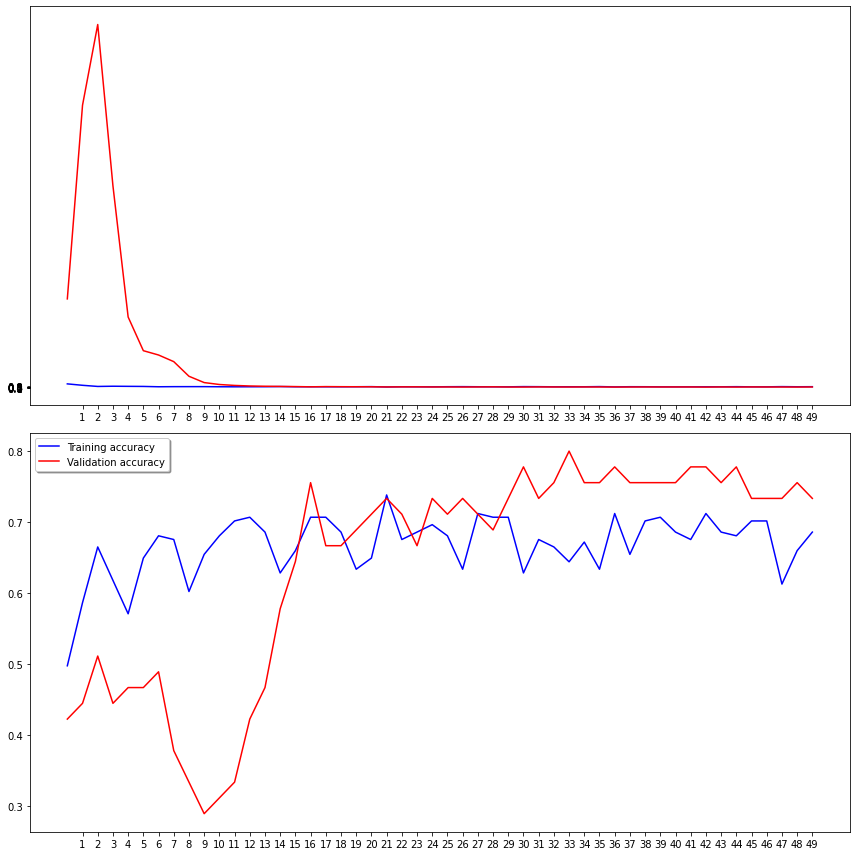

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [25]:
test_filenames = os.listdir('../AIBabySitter/database/test')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [26]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
   '../AIBabySitter/database/test', 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 15 validated image filenames.


In [27]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [28]:
test_df['category'] = np.argmax(predict, axis=-1)

In [29]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [30]:
test_df['category'] = test_df['category'].replace({ 'safe': 1, 'unsafe': 0 })

<AxesSubplot:>

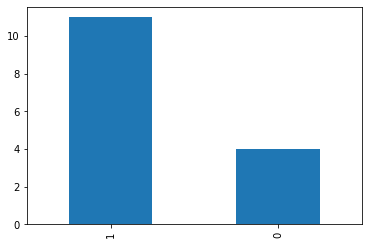

In [31]:
test_df['category'].value_counts().plot.bar()

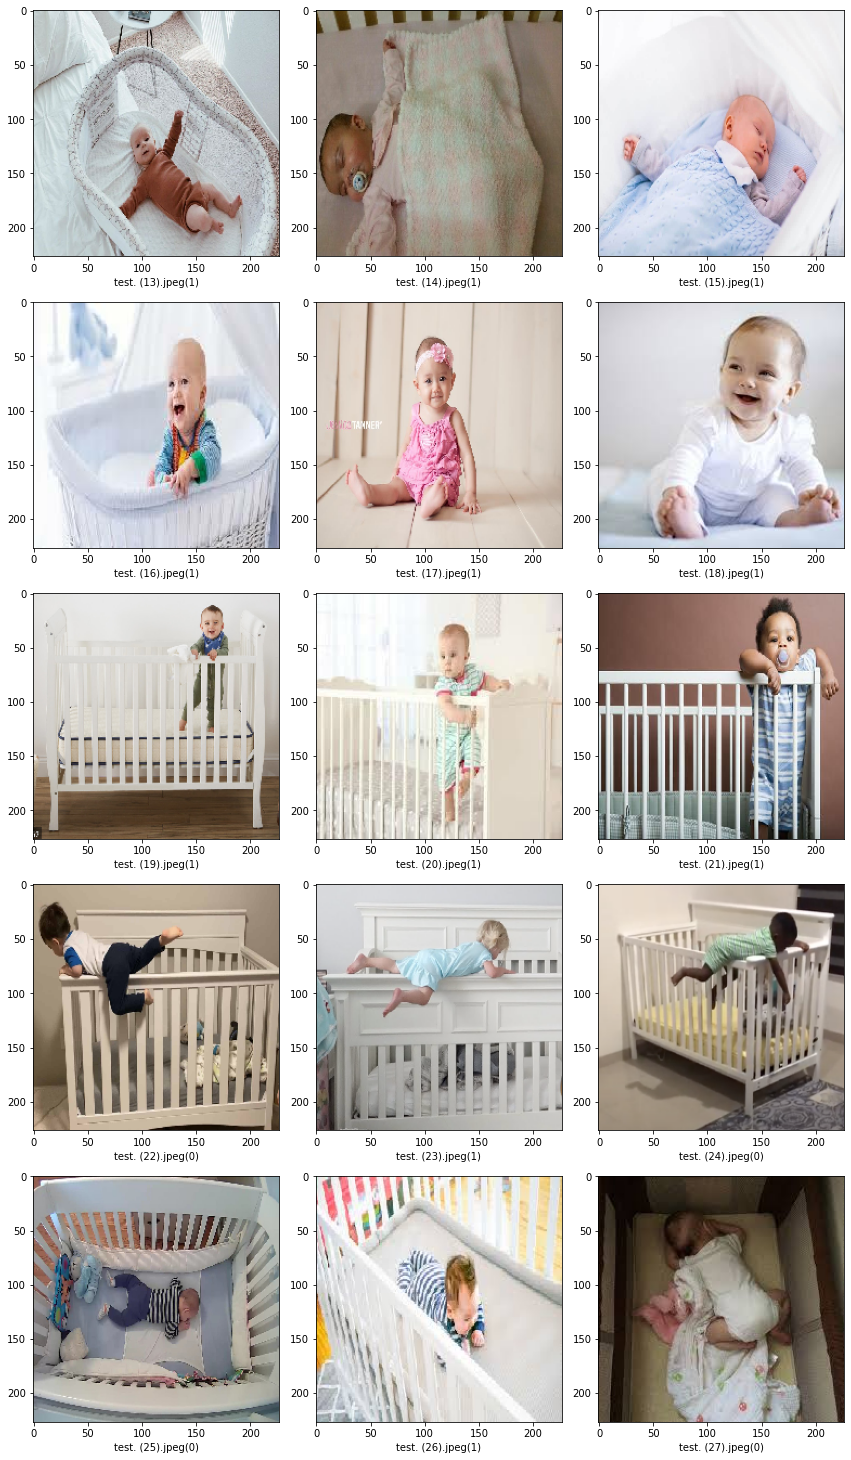

In [32]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('../AIBabySitter/database/test/'+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()